# Using pretrained MobileNetV2

Here we want to use a pre-trained mobile net and train it on the hand images from before. If we use the model already implemented in keras, we can use the weights from ImageNet.

# importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model
#from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

from PIL import Image # used for loading images
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
#from IPython.display import Image
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt


In [2]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\werth\\AppData\\Local\\Continuum\\anaconda3\\envs\\workshop\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


# The model
## Loading the mobileNet model without top

In [7]:
base_model=MobileNetV2(input_shape=(224,224,3), weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model=ResNet50(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5,seed=42)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3

output=Dense(2,activation='softmax')(x) #final layer with softmax activation

#specify the inputs
#specify the outputs
model=Model(inputs=base_model.input,outputs=output)
#now a model has been created based on our architecture

## visualize models to compare with and without top

Run cell before, once with include_top False and True

In [ ]:
for i,layer in enumerate(model.layers):
   print(i,layer.name)
    

You can also export the graphic to a image file

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')


## What happens when removing the last dense layers (on top)?

the weights in a convolutional layer are fixed-size. They are the size of the kernel x filters. Example: a 3x3 kernel of 10 filters. A convolutional layer doesn't care about the size of the input image. It just does the convolutions and present a resulting image based on the size of the input image. (Search for some illustrated tutorials about convolutions if this is unclear)

now the weights in a dense layer are totally dependent on the input size. It's one weight per element of the input. So this demands that your input be always the same size, or else you won't have proper learned weights.

Because of this, removing the final dense layers allows you to define the input size (see in documentation). (And the output size will increase/decrease accordingly)

Thanks to great stackoverflower [Daniel Möller](https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller)

## Fixing the layers to not be trainable

The model is set up like a numpy array where you can reach each layer by itself. You can set now all layers of the base model frozen.
important is that after setting layer trainable =False, the model has to `be compile()` to take effect.


See Keras [webside](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)

In [8]:
# freez all layers before dense output 
n=154 #mobileNet,  
# n=174 #ResNet50
for layer in model.layers[:n]:
    layer.trainable=False
for layer in model.layers[n:]:
    layer.trainable=True
    
    
for layer in model.layers: print(layer, layer.trainable)              

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BD80E9E358> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BD80E9E4E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BD80E9EE10> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001BD80E9EE48> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001BD80F9CDA0> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x000001BD80E78F98> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001BD80F675C0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001BD808AA898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BD81459F60> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x000001BD81356278> False
<tensorflow.python.keras.layers.convolut

In [ ]:
model.summary()

In [10]:
opt = tf.keras.optimizers.Adam()
# opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.99)#, clipvalue=0.5,
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])



For optimal throughput you can use a double-buffering approach where the next request is already being prepared (by the CPU) while the current one is still being processed (by the GPU). This way the CPU and GPU are never waiting for one another.

---

# Training model
## Loading the data with data generator

Now we use the generator function again to load the data for training

In [11]:
datagen =ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=[0.5,1.0],
                                     brightness_range=[0.2,1.0],              
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     data_format='channels_last'
                           )

#datadirectory='E:/fotos/haende/gen_structured/input/'
#Tsize=[512,512]
datadirectory='./Data/Hands_orig_224_224/input/'
Tsize=[224,224]
 
train_batch_generator =datagen.flow_from_directory(directory=datadirectory + "Train/",
                                     classes=['Faust', 'Offen'],
                                     target_size=Tsize,
                                     class_mode='categorical',              
                                     batch_size=20,
                                     color_mode='rgb',
                                     shuffle=True,
                                     seed=42)

valid_batch_generator =datagen.flow_from_directory(directory=datadirectory + "Validate/",
                                     classes=['Faust', 'Offen'],
                                     target_size=Tsize,
                                     class_mode='categorical',
                                     #batch_size=10,
                                     color_mode='rgb',
                                     shuffle=True,
                                     seed=42)

#img_batch = next(batches)



Found 236 images belonging to 2 classes.
Found 58 images belonging to 2 classes.


## Callbacks

In [12]:
import os
# filepath='./models/ResNet50.h5'
filepath='./models/RMobileNetV2h5.h5'

Checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,               
    monitor='val_accuracy',
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=1)


stop_callback=keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.01, 
    patience=20, 
    restore_best_weights=True)

## Training the model

In [13]:
%%time
step_size_train=train_batch_generator.n//train_batch_generator.batch_size
step_size_valid=valid_batch_generator.n//valid_batch_generator.batch_size

step_size_train=60 # If we use Data augmentation with fit_generator, you can use more samples than you have, as they are generated differently on the fly



history=model.fit_generator(generator=train_batch_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_batch_generator,
                    epochs=10,
                    callbacks=[Checkpoint_callback])

Epoch 1/10
60/60 [==============================] - 132s 2s/step - loss: 0.5134 - accuracy: 0.7898 - val_loss: 0.2688 - val_accuracy: 0.8793
Epoch 2/10
60/60 [==============================] - 134s 2s/step - loss: 0.3380 - accuracy: 0.8466 - val_loss: 0.2506 - val_accuracy: 0.9138
Epoch 3/10
60/60 [==============================] - 141s 2s/step - loss: 0.3559 - accuracy: 0.8398 - val_loss: 0.4709 - val_accuracy: 0.7586
Epoch 4/10
60/60 [==============================] - 138s 2s/step - loss: 0.2777 - accuracy: 0.8797 - val_loss: 0.2951 - val_accuracy: 0.8621
Epoch 5/10
60/60 [==============================] - 128s 2s/step - loss: 0.3219 - accuracy: 0.8661 - val_loss: 0.4792 - val_accuracy: 0.7414
Epoch 6/10
10/60 [====>.........................] - ETA: 1:55 - loss: 0.3007 - accuracy: 0.8878

KeyboardInterrupt: 

# Evaluating the model 

## Tensorboard

before training the model we activate tensorboard. Tensorboard can monitor the training and validation of the model and visualize the process. Thereby we can identify where optimization is needed.

you can load the tensorboard in another tab

In [ ]:
def tb(logdir="logs", port=6006, open_tab=True, sleep=2):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port), shell=True)
    if open_tab:
        import time
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

server1=tb()               # Starts a TensorBoard server on the logs directory, on port 6006
                           # and opens a new tab in your browser to use it.

#server2=tb("logs2", 6007)  # Starts a second server on the logs2 directory, on port 6007,
                            # and opens a new tab to use it.

In [ ]:
# and later...
server1.kill()  # stops the first server  

Or you can use the Tensorboard within jupyter notebook with the new Tensorflow2. It depends on your preferrence what suits your style better

In [ ]:
import datetime, os
%load_ext tensorboard.notebook

logs_base_dir = ".\logs"#create folder for 
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

To kill a Tensorboard in Windows use CMD : taskkill /IM "tensorboard.exe" /F

Alternatively you can also use a file writer and save the information in the folder. Than you can call the tensorboard via the console and open tensorboard in another tab

In [ ]:
writer = tf.summary.FileWriter( "./logs", tf.get_default_graph())
%tensorboard --logdir=.\logs

# Simply printing the history

In [77]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


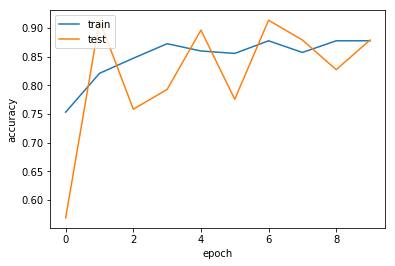

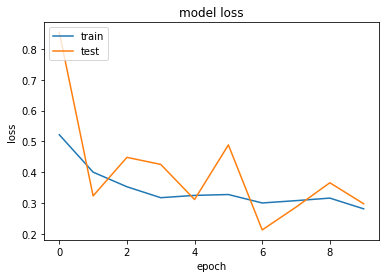

In [155]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#  Saving the model

In [156]:
import time
import os
name='MobileNetV2'
saved_model_path = './pb_models/' + name 
os.mkdir(saved_model_path)
tf.saved_model.save(model, saved_model_path)
saved_model_path

'./pb_models/MobileNetV2'

## Saving a model able to be served 

In [ ]:
import time
saved_model_path = "./pb_models/experimental/{}".format(int(time.time()))

tf.keras.experimental.export_saved_model(model, saved_model_path)
saved_model_path